In [1]:
import numpy as np
from astropy import coordinates as coor

In [18]:
data=np.load("att_oct_data.npz",allow_pickle=True)
[a for a in data.keys()]

['dt2', 'sat_coords', 'mag_calc', 'mag_meas', 'sun_meas', 'angle', 'sun_vec']

In [7]:
dt2=data['dt2']
sat_coords=data['sat_coords']

In [8]:
sat_mov=sat_coords[:,1:]-sat_coords[:,:-1]
sat_mov.shape

(3, 146)

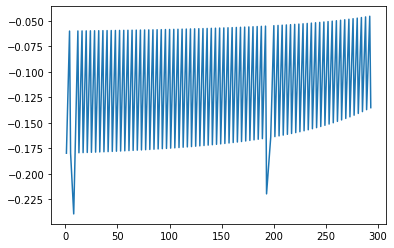

In [13]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot(dt2,sat_mov[1][1:])

In [36]:
pfinex4=[3.46508217e+01, 2.61204706e+02, 8.52427661e+00, 2.31146590e+02, 9.85928507e-07, 7.56426794e+01, 2.17786890e+00, 5.52031335e-03,       5.27567832e-03]
def phi_fun(period,phi0,samp,sphase=90,accel=0):
    '''predict phase with some sinusoidal modulation (samp, sphase) and period gradient (accel)
    '''
    phi_max=phi0+360*(dt2/period+dt2**2*accel)
    phi_max-=360*(phi_max/360).astype(int)
    return phi_max+samp*np.sin(np.deg2rad(phi_max-sphase))

bangs=phi_fun(*pfinex4[:5])#[wsel]

In [40]:
mag_calc=data['mag_calc']
sun_vec=data['sun_vec']
mbody=data['mag_meas']

In [26]:
import satutils as su
sunvec_eci=np.array([su.fromangle(s.ra.value,s.dec.value) for s in sun_vec[1:-1]])
angle3=np.array([np.arccos(np.dot(mag_calc[i],sunvec_eci[i])) for i in range(len(dt2))])

In [55]:
#su.triad
i=10
eci_tr=su.triad(mag_calc[i],sunvec_eci[i])

In [34]:
satcoor2=[coord.EarthLocation.from_geodetic(r[0],r[1],r[2]*1e3) for r in sat_coords.T] 
z_axis=[coord.SkyCoord(from_cart(),unit="deg",frame="altaz",location=satcoor2[i],obstime=times[i]) for i in [0,-1]]


In [51]:
dphi,dtheta=pfinex4[-2:]#0.05,0.05
zaxis=[np.cos(dphi)*np.sin(dtheta),np.sin(dphi)*np.sin(dtheta),np.cos(dtheta)]
#zaxis
aliad=[su.triad(m,zaxis) for m in mbody]


In [65]:
#angle2=data['angle']
eci_body=[]
for i in range(len(dt2)):
    eci_tr=su.triad(mag_calc[i],sunvec_eci[i])
    phi=np.deg2rad(bangs[i])
    awee=np.array([np.cos(angle2[i]),np.sin(angle2[i])*np.cos(phi),np.sin(angle2[i])*np.sin(phi)])# sun dir in EQ frame
    asun=aliad[i].T@awee
    body_tr=su.triad(mbody[i],asun)
    eci_body.append(eci_tr.T@body_tr)

In [66]:
eci_body=np.array(eci_body)

In [69]:
ex,ey,ez=eci_body[:,:,2].T  #coordinates of Z+ axis in equatorial CS

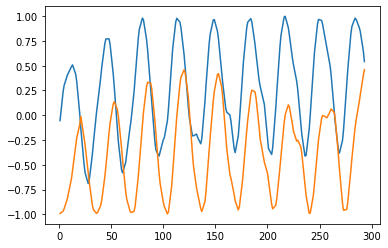

In [71]:
pl.plot(dt2,ez)
pl.plot(dt2,ex)

In [68]:
trans[:,2]

array([-0.22113231,  0.8427924 , -0.49057264])